# Quantum Inspire performance test

We compare performance of the simulator with the circuit from 

"Overview and Comparison of Gate Level Quantum Software Platforms", https://arxiv.org/abs/1807.02500

Pieter Eendebak <pieter.eendebak@tno.nl>

# Define the circuit

In [2]:
from IPython.display import Math
import numpy as np
import itertools
import warnings
from colorama import Fore
from imp import reload
from getpass import getpass

# importing the QISKit
import qiskit
from qiskit.tools.visualization import circuit_drawer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QISKitError
from qiskit import available_backends, execute, register, get_backend, compile
from qiskit.tools.qi.qi import state_fidelity, concurrence, purity, outer
from qiskit.tools.visualization import plot_state, plot_histogram
from sympy.interactive import printing
printing.init_printing(use_latex='png')
from IPython.display import display, Math, Latex

from requests.auth import HTTPBasicAuth
from quantuminspire import QuantumInspireAPI
from quantuminspire.qitools import format_vector, run_circuit

We define the circuit based on the number of qubits and the depth (e.g. the number of iterations of the unit building block).

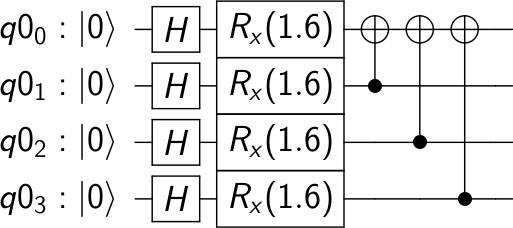

In [3]:
def pcircuit(nqubits, depth = 10):
    q = QuantumRegister(nqubits)
    qc = QuantumCircuit(q)

    for level in range(depth):
        for qidx in range(nqubits):
            qc.h( q[qidx] )
        qc.barrier()
        for qidx in range(nqubits):
            qc.rx(np.pi/2, q[qidx])
        qc.barrier()
            
        for qidx in range(nqubits):
            if qidx!=0:
                qc.cx(q[qidx], q[0])
                
    return q, qc

q,qc=pcircuit(4, 1)
cplot=circuit_drawer(qc)
display(cplot)

# Run the cirquit on the Quantum Inspire simulator

First we make a connection to the Quantum Inspire website.

In [4]:
try:
    passwd
except:
    print('Enter username')
    username = input();
    print('Enter password')
    passwd = getpass();

auth = HTTPBasicAuth(username, passwd)
qi = QuantumInspireAPI(server=r'https://api.quantum-inspire.com/', auth=auth)  
_=qi.list_backends()

Enter username
peendebak
Enter password
········
backend: qxsim (qubits 32)
backend: qxsim-ss (qubits 31)


We create a QisKit backend for the Quantum Inspire interface and execute the circuit generated above.

In [7]:
from quantuminspire.qiskit.qiskit_backend import QiSimulatorPy
backend=QiSimulatorPy(qi_api=qi)    
j=execute(qc, backend)

no measurements in circuit 'circuit1', classical register will remain all zeros.


run_circuit: nshots 1024
generate_cqasm: 4 qubits

submitting qasm code to quantum inspire qi-tmpjob-9b6130e3-95cf-11e8-9642-80fa5b08c98e
waiting for result of job 169 (iteration 0)
waiting for result of job 169 (iteration 1)
waiting for result of job 169 (iteration 2)
waiting for result of job 169 (iteration 3)
waiting for result of job 169 (iteration 4)
result of job 169 is COMPLETE


We can print the results and also show the cQASM that was generated.

In [8]:
print(Fore.BLUE+'Generated histogram:' + Fore.RESET)
print(j.get_counts())
print(Fore.BLUE+'Generated cQASM:' + Fore.RESET)
print(backend._cqasm[0:101] + '\n....\n' + backend._cqasm[-100:])

Generated histogram:
{'5': 48.0, '2': 68.0, '3': 68.0, '13': 52.0, '10': 88.0, '15': 24.0, '11': 80.0, '14': 24.0, '9': 64.0, '12': 92.0, '0': 80.0, '1': 88.0, '6': 80.0, '4': 56.0, '8': 52.0, '7': 60.0}
Generated cQASM:
version 1.0
# cqasm generated by QI backend for QisKit
qubits 4
H q[3]
H q[2]
H q[1]
H q[0]
Rz q[2], 
....
, q[0]
CNOT q[3], q[0]
.measurement
   measure q[0]
   measure q[1]
   measure q[2]
   measure q[3]



Visualization can be done with the normal Python plotting routines, or with the QisKit SDK.

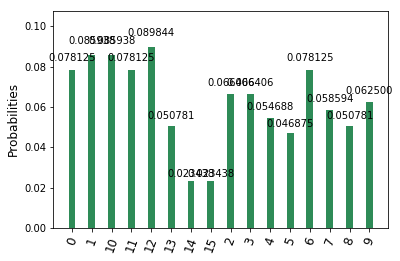

In [9]:
plot_histogram(j.get_counts(qc))

To compare we will run the circuit with 20 qubits and depth 20. This takes:

* QisKit: 3.7 seconds
* ProjectQ: 2.0 seconds

In [15]:
q,qc=pcircuit(20, 20)
j=execute(qc, backend)

run_circuit: nshots 1024
generate_cqasm: 4 qubits

submitting qasm code to quantum inspire qi-tmpjob-4043403b-910b-11e8-a42e-e4a4713a4548
waiting for result of job 122 (iteration 0)
waiting for result of job 122 (iteration 1)
waiting for result of job 122 (iteration 2)
waiting for result of job 122 (iteration 3)
result of job 122 is COMPLETE


## Notes

The implementation of the $sqrt(X)$ gate was done a series of $R_z$ and $R_y$ rotations.

In [8]:
# decompose U from 
#https://quantumexperience.ng.bluemix.net/qx/tutorial?sectionId=full-user-guide&page=002-The_Weird_and_Wonderful_World_of_the_Qubit~2F004-advanced_qubit_gates
I=1j
from numpy import cos, sin
import sympy as sp
from sympy import exp,pprint
from sympy.functions.elementary.trigonometric import cos,sin

theta,psi,phi,l = sp.symbols('theta psi phi lambda')

A=np.matrix([[1,0],[0,sp.exp(I*phi)]])
B=np.matrix([[cos(theta/2),-sin(theta/2)],[sin(theta/2),cos(theta/2)]])
C=np.matrix([[1,0],[0,sp.exp(I*l)]])
pprint(A*B*C)


               [[cos(theta/2) -exp(1.0*I*lambda)*sin(theta/2)]               
 [exp(1.0*I*phi)*sin(theta/2) exp(1.0*I*lambda)*exp(1.0*I*phi)*cos(theta/2)]]
